# Recommender System

This exercise extends on an example Jupyter notebook with an implementation of a recommender system to suggest movies to users. Data files are collected from the source and used to build the recommender system.

The Recommender System calculates movie suggestions for a given user by calculating  similarities between the users latest rated movie(s) and other movies. Similarity between movies is calculated using Pearson coefficient between user ratings of each movie. Similar movies are then ranked in descending order by Pearson coefficient and the first ___x___ movies are taken as recommendations for the user.
This is a basic implementation of a Collaborative Filtering system. For example, there is no post processing in case of multiple movies with similar Pearson coefficient (no tie breaker). Also, no other information about the movies or the users (ex. genres or release year).

The following extensions are added to develop the example further: 

1. Split data into train/test and implement the following evaluation metrics for the Recommender System:
    * __MAP @ k__: Mean Average Precision where precision @ ___k___ is a percentage of correct items among first ___k___ recommendations.
    * __Coverage__: Percentage of movies that can be recommended in the test data.
    * __Personalization__: Score indicating how user dissimilar user recommendations are from each other. It is computed as __1 - Cosine Similarity of user recommendations__.
2. Improve the Recommender System on at least one of the metrics in __(1)__.
3. Document all the modifications to the model and present a comparative report showing the improvement in evaluation metrics.

In [1]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-cp37-none-any.whl size=9686 sha256=4c5b344a8d0284724175e81bb1b641098efea26b4a015bafc0895cdfa40d437c
  Stored in directory: C:\Users\Ashwin\AppData\Local\pip\Cache\wheels\40\15\30\7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [19]:
import pandas as pd
import numpy as np
import zipfile
import wget
import os.path
from os import path
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import pickle
import time
pd.set_option('display.max_colwidth', -1)

## Download and read the input data
* Download data files from 'http://files.grouplens.org/datasets/movielens/'
* Reading csv files containing data 
* "ratings.csv" contains all user movie ratings with a timestamp
* "movies.csv" contains information about teh movies such as the genres

In [2]:
if  not path.exists("ml-20m.zip"):
    url = 'http://files.grouplens.org/datasets/movielens/ml-20m.zip'
    filename = wget.download(url)
if  not path.exists("ml-20m"):    
    with zipfile.ZipFile('ml-20m.zip', 'r') as zip_ref:
        zip_ref.extractall('.')
all_reviews = pd.read_csv('./ml-20m/ratings.csv')
all_items = pd.read_csv('./ml-20m/movies.csv')


## Method to prepare the data
* This function creates a user/item matrix with the ratings as values, NaN means no user in row did not rate movie in column

In [3]:
def get_user_item_matrix(sample_size):
    reviews = all_reviews.head(int(all_reviews.shape[0]*sample_size))
    r = reviews.groupby(['userId','movieId'], as_index=False)['rating'].max()            
    data = r[['movieId','userId','rating']]
    d_ = data.pivot(index='userId', columns='movieId', values='rating')
    matrix = d_.dropna(thresh=2) #remove users that rated less than 2 movies 
    matrix = matrix.dropna(thresh=10,axis=1) #remove movies that have been rated by less than 10 users
    return matrix   

## Method to calculate the recommendations
* This function takes as arguments the user/item matrix, a vector of movie Ids rated by the user (possibly one) and the number of recommendations we would like to have.
* It finds correlated movies to the ones rated by the user.
* Returns the K most correlated movies (K given as argument).

In [4]:
def recommend_items(matrix,user_items,k):
    recommended_items = pd.DataFrame(columns=['items','score'])
    for item in user_items:
        item_vector = matrix[item]
        corr_results = matrix.corrwith(item_vector)
        corr_results = corr_results.where(corr_results > 0).dropna().sort_values(ascending=False)    
        similar_items = pd.DataFrame(corr_results.head(k))
        similar_items = similar_items.reset_index()
        similar_items.columns =  ['items','score']
        recommended_items = pd.concat([recommended_items,similar_items])
        if recommended_items[recommended_items.score == 1].shape[0] >= k:
                break

    if ~recommended_items.empty:  
        recommended_items = recommended_items[~recommended_items['items'].isin(user_items)] 
        recommended_items = recommended_items.sort_values(by=['score'], ascending=False)
        recommended_items.drop_duplicates(inplace=True)

    return recommended_items.head(k)


## Method to display the results
* Prints a DataFrame of movies rated by the User
* Prints a DataFrame of movies recommended to the User


In [5]:
def display_items(item_list):   
    display(all_items[all_items['movieId'].isin(item_list)])

def show_recommendations(user_id,recommendations,nb_rated_movies):
    items_names = all_reviews.loc[all_reviews['userId']==user_id].sort_values(by='timestamp', ascending=False).iloc[:nb_rated_movies]['movieId'].values
    #turned into pure list instead of list comprehension
    print('\n\033[1mUser \"{}\" latest rated movie:\033[0m\n'.format(user_id))
    display_items(items_names)
    print('\n\n\033[1mRecommendations for user \"{}\":\033[0m\n'.format(user_id))
    display_items(recommendations['items'])

## Method to get the recommendation 
* Get the latest movied rated by a given User and a user/item matrix
* Calls 'recommend_items' with the latest movie rated by the User
* Returns the recommendations

In [7]:
def get_recommendations_pear(user_id,matrix,nb_rated_movies,number_of_recommendations = 5):
    success_threshold = 3
    usr_vals = all_reviews.loc[all_reviews['userId']==user_id].sort_values(by='timestamp', ascending=False)
    items_names = usr_vals[usr_vals['rating']> success_threshold ].iloc[:nb_rated_movies]['movieId'].values     
    #changed item_names to include most recent well like movies
    recommendations = recommend_items(matrix,items_names,number_of_recommendations)
    return recommendations

In [233]:
sample_size=0.005
matrix = get_user_item_matrix(sample_size)
nonan_matrix = matrix.replace(np.nan,-1)

In [237]:
user_id = 2
nb_last_rated_movies = 3
number_of_recommendations = 5
#made number_of_recommendations public facing
try:
    recommendations = get_recommendations_pear(user_id,nonan_matrix, nb_last_rated_movies, number_of_recommendations)
    show_recommendations(user_id,recommendations,nb_last_rated_movies)
except:
    print('{} is an invalid User ID. Please enter a user ID between {} and {}.'.format(user_id,1,len(matrix.index.unique()))) 
    #changed error parameters


User "2" latest rated movie:



,movieId,title,genres
907,924,2001: A Space Odyssey (1968),Adventure|Drama|Sci-Fi
1242,1270,Back to the Future (1985),Adventure|Comedy|Sci-Fi
1684,1748,Dark City (1998),Adventure|Film-Noir|Sci-Fi|Thriller




Recommendations for user "2":



,movieId,title,genres
1171,1196,Star Wars: Episode V - The Empire Strikes Back (1980),Action|Adventure|Sci-Fi
1180,1206,"Clockwork Orange, A (1971)",Crime|Drama|Sci-Fi|Thriller
1212,1240,"Terminator, The (1984)",Action|Sci-Fi|Thriller
1263,1291,Indiana Jones and the Last Crusade (1989),Action|Adventure
1927,2011,Back to the Future Part II (1989),Adventure|Comedy|Sci-Fi


## Method to split the data into train and test set
* Splits data by user/item matrix where a certain fraction of users will be separated
* method returns a tuple: (training set matrix, testing set matrix)


In [8]:
def train_test_split(matrix, split):
    split_len = int(matrix.shape[0]*(1-split))
    train_index = matrix.index[:split_len]   
    test_index = matrix.index[split_len:]
    return (matrix.loc[train_index,:], matrix.loc[test_index,:])
 

## Method to support cross validation, split data into kth fold
* Splits user/item matrix into the kth fold crossvalidation set
* Arguments: matrix to be split, k number of folds, current fold cur

<i>is not currently in use </i>

In [9]:
def crossval_mat(matrix, k, cur):
    indx = np.array_split(matrix.index.values, k)
    train_inds = [i for i in range(0,k) if i != cur] #list of [0,1,2...] except for the kth fold in the list
    train_arr = np.array([])
    for inds in train_inds:
        train_arr = np.append(train_arr, indx[inds])
    return(matrix.loc[train_arr.astype(int),:], matrix.loc[indx[cur],:])
    

## Utility function to create a list of predictions
* Utility function used to create a list of lists of predictions
* Each list contains movie_id of recommendations where recommendations are found using models
* Switch meth can be used to switch between Pearson model or NMF model

In [33]:
def list_of_predictions(matrix, train_matrix, nb_last_rated_movies, number_of_recommendations, meth = 'pear'):
    predicted = []
    verbose = False
    for i in matrix.index:
        if verbose:
            print('Current user_id under investigation: '+ str(i))
        try:
            if meth == 'pear':
                predicted.append(get_recommendations_pear(i,train_matrix.fillna(-1), nb_last_rated_movies, number_of_recommendations)['items'].values.astype(int))
            elif meth == 'nmf':
                predicted.append(get_recommendations_nmf(i,train_matrix.fillna(0), nb_last_rated_movies, number_of_recommendations)['items'].values.astype(int))
        except:
            predicted.append(np.array([]))       
    return predicted    

## Methods to calculate MAP @ K
* Finds 'actual' results by counting movies rated greater than a success threshold
* Function mapk_matrix is the primary api
* arguments to the function includes list of lists of predictions
* list of lists should be ordered by user_id in testing set
* argument also includes testing user/item matrix


In [28]:
#modified from https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/average_precision.py

def _apk(actual, predicted, k=10):
    
    #short circuit if predicted or actual is empty
    if not actual.size or not predicted.size:
        return 0.0

    score = 0.0
    num_hits = 0.0
    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    return score / min(len(actual), k)

def _mapk(actual, predicted, k=10):
    return np.mean([_apk(a,p,k) for a,p in zip(actual, predicted)])

def mapk_matrix(matrix, predicted, number_of_recommendations, nb_rated_movies):
    actual = []
    success_threshold = 3
    for i in matrix.index:
        #below two code lines finds all movies that the user rated above a success threshold
        #EXCEPT for movies being used to find similarities defined by 'nb_rated_movies'
        usr_vals = all_reviews.loc[all_reviews['userId']==i].sort_values(by='timestamp', ascending=False)
        items_names = usr_vals[usr_vals['rating']> success_threshold ].iloc[nb_rated_movies:]['movieId'].values     
        actual.append(items_names)
    
    return _mapk(actual, predicted, number_of_recommendations)

## Method to calculate Coverage
* Using list of lists of predictions and all possible movie_ids, coverage is calculated
* Datastructure 'set' is used to quickly find unique movie_ids


In [12]:
def coverage(predicted, train_matrix):
    all_mov = len(set(train_matrix.columns.values))
    predicted_set = len(set(np.concatenate(predicted).astype(int)))
    return predicted_set/all_mov
    

## Method to calculate Personalization
* The testing set and list of lists of predictions is used to calculate personalization
* binary indicator matrix is created to find which movies were recommended to each user in test set
* cosine similarity matrix between users is then found and upper triangle (w/o diagonal) average is found
* 1- average of the upper triangle of the cosine similarity matrix is the personalization

In [13]:
def personalization(test, predicted):
    from sklearn.metrics.pairwise import cosine_similarity

    test_cp = test.copy()    
    for col in test_cp.columns:
        test_cp[col].values[:] = np.nan

    ctr = 0
    for pred in predicted:
        idx = test_cp.index[ctr]
        for mov in pred:
            test_cp.loc[idx,mov] = 1
        ctr += 1
    
    cos_sim_ut = np.triu(cosine_similarity(test_cp.fillna(0)),1)
    del test_cp
    return (1 - (sum(sum(cos_sim_ut))/sum(sum(cos_sim_ut>0))))

In [53]:
scores = pd.DataFrame({'map5':[0,0,0,0],'coverage':[0,0,0,0],'personalization':[0,0,0,0],'time':[0,0,0,0]},index=['pearson','pearson_nopop','nmf','nmf_nopop'])

## Example script for calculating all measures using Pearson similarity
* test set recommendations calculated by the pearson similarity scores are meausred using all three metrics
* time to run the script is also calculated 

In [54]:
tm = time.time()
sample_size=0.005
nb_last_rated_movies = 3
number_of_recommendations = 5

matrix = get_user_item_matrix(sample_size)
train,test = train_test_split(matrix, 0.3)

predicted = list_of_predictions(test, train, nb_last_rated_movies, number_of_recommendations)
map_k = mapk_matrix(test, predicted, number_of_recommendations, nb_last_rated_movies)

scores.loc['pearson','map5'] = map_k
scores.loc['pearson','coverage'] = coverage(predicted, train)
scores.loc['pearson','personalization'] = personalization(test, predicted)
scores.loc['pearson','time'] = time.time()-tm

print('The MAP @ {} measure is: {} '.format(number_of_recommendations, map_k))
print('The Coverage measure is: {} '.format(scores.loc['pearson','coverage']))
print('The Personalization measure is: {} '.format(scores.loc['pearson','personalization']))
print('Time: ' + str(scores.loc['pearson','time']))

The MAP @ 5 measure is: 0.0722432859399684 
The Coverage measure is: 0.20027560863573726 
The Personalization measure is: 0.729781662947234 
Time: 494.37110328674316


## Removing very popular movies
* Long tail plots show some movies are very popular, biasing recommemdations and can be removed
* All measures are calculated after removing very popular movies that have been rated by more than 20% of the users

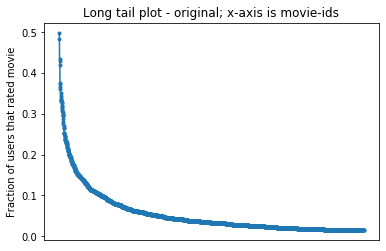

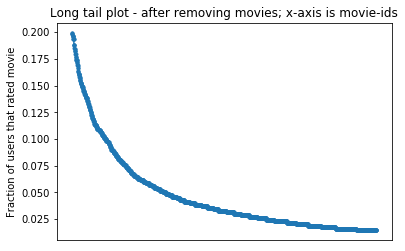

In [55]:
pop_movs = matrix.notnull().sum().sort_values(ascending=False)/matrix.shape[0]

#-----------------
plt.plot(pop_movs.values,'.-')
frame1 = plt.gca()
frame1.axes.get_xaxis().set_visible(False)
plt.title('Long tail plot - original; x-axis is movie-ids')
plt.ylabel('Fraction of users that rated movie')
plt.show()

#-----------------

pop_movs = matrix.drop(pop_movs[pop_movs > .2].index,axis=1).notnull().sum().sort_values(ascending=False)/matrix.shape[0]
#-----------------
plt.plot(pop_movs.values,'.-')
frame1 = plt.gca()
frame1.axes.get_xaxis().set_visible(False)
plt.title('Long tail plot - after removing movies; x-axis is movie-ids')
plt.ylabel('Fraction of users that rated movie')
plt.show()
#-----------------


In [56]:
tm = time.time()

pop_movs = matrix.notnull().sum().sort_values(ascending=False)/matrix.shape[0]
matrix = matrix.drop(pop_movs[pop_movs > .2].index,axis=1)

train,test = train_test_split(matrix, 0.3)
predicted = list_of_predictions(test, train, nb_last_rated_movies,number_of_recommendations)
map_k = mapk_matrix(test, predicted, number_of_recommendations, nb_last_rated_movies)

scores.loc['pearson_nopop','map5'] = map_k
scores.loc['pearson_nopop','coverage'] = coverage(predicted, train)
scores.loc['pearson_nopop','personalization'] = personalization(test, predicted)
scores.loc['pearson_nopop','time'] = time.time()-tm

print('The MAP @ {} measure is: {} '.format(number_of_recommendations, map_k))
print('The Coverage measure is: {} '.format(scores.loc['pearson_nopop','coverage']))
print('The Personalization measure is: {} '.format(scores.loc['pearson_nopop','personalization']))
print('Time: ' + str(scores.loc['pearson_nopop','time']))

The MAP @ 5 measure is: 0.030489731437598734 
The Coverage measure is: 0.16223908918406071 
The Personalization measure is: 0.7523846347641358 
Time: 352.3970341682434


## Finding similarities using non-negative matrix factorization (NMF)
* Find factorized matrix: movie/factor
* Find similarities of most recent highly rated user selected movies using factorized matrix
* Return movies 5 highest scoring movies
* 50 components used in example
* Once factorized matrix is calculated, it is saved as a pickled file and will be loaded when needed; saves computational time re-calculating matrix


In [40]:
def get_recommendations_nmf(user_id,matrix,nb_rated_movies,number_of_recommendations = 5):
    success_threshold = 3
    usr_vals = all_reviews.loc[all_reviews['userId']==user_id].sort_values(by='timestamp', ascending=False)
    items_names = usr_vals[usr_vals['rating']> success_threshold ].iloc[:nb_rated_movies]['movieId'].values     
    #changed item_names to include most recent well like movies
    recommendations = recommend_nmf(matrix, items_names, number_of_recommendations, 50)
    return recommendations

def recommend_nmf(matrix, items_names, number_of_recommendations, nmf_comp=20):

    if  path.exists("train.raw"):
        df = pickle.load(open("train.raw", "rb")) #loaded previously calculated factor matrix
    else:
        from sklearn.pipeline import make_pipeline
        from sklearn.decomposition import NMF
        from sklearn.preprocessing import Normalizer,MaxAbsScaler

        scaler = MaxAbsScaler()
        nmf = NMF(n_components=nmf_comp)
        normalizer = Normalizer()
        pipeline = make_pipeline(scaler,nmf,normalizer)
        norm_features = pipeline.fit_transform(matrix.T.fillna(0)) #transpose to create movie/factor matrix
        df = pd.DataFrame(norm_features)
        df.index = train.T.index 
        pickle.dump(df, open("train.raw", 'wb'))
    
    recommended_items = pd.DataFrame(columns=['items','score'])
    
    for name in items_names:
        if name in df.index:
            similar_items = df.dot(df.loc[name]).nlargest(6)[1:].reset_index()
            similar_items.columns =  ['items','score']
            recommended_items = pd.merge(recommended_items,similar_items,how='outer')
    
    recommended_items = recommended_items.sort_values(by=['score'],ascending=False).reset_index(drop=True)
    
    #Below loop removed movie_ids that were used to find similarities from recommendations
    for name in items_names:
        recommended_items = recommended_items.drop(recommended_items[recommended_items['items'] == name].index)
    
    return recommended_items.head(number_of_recommendations)

## Example script for calculating all measures using NMF similarity
* test set recommendations calculated by the NMF similarity scores are meausred using all three metrics
* time to run the script is also calculated 

In [57]:
tm = time.time()
try:
    os.remove("train.raw")
except:
    pass

sample_size=0.005
nb_last_rated_movies = 3
number_of_recommendations = 5

matrix = get_user_item_matrix(sample_size)
train,test = train_test_split(matrix, 0.3)

predicted = list_of_predictions(test, train, nb_last_rated_movies,number_of_recommendations, meth = 'nmf')
map_k = mapk_matrix(test, predicted, number_of_recommendations, nb_last_rated_movies)

scores.loc['nmf','map5'] = map_k
scores.loc['nmf','coverage'] = coverage(predicted, train)
scores.loc['nmf','personalization'] = personalization(test, predicted)
scores.loc['nmf','time'] = time.time()-tm

print('The MAP @ {} measure is: {} '.format(number_of_recommendations, map_k))
print('The Coverage measure is: {} '.format(scores.loc['nmf','coverage']))
print('The Personalization measure is: {} '.format(scores.loc['nmf','personalization']))
print('Time: '+str(scores.loc['nmf','time']))

The MAP @ 5 measure is: 0.09101105845181674 
The Coverage measure is: 0.264584290307763 
The Personalization measure is: 0.7147178932708856 
Time: 50.166861057281494


## NMF Similarities after removing very popular movies
* Long tail plots show some movies are very popular, biasing recommemdations and can be removed
* All measures are calculated after removing very popular movies that have been rated by more than 20% of the users

In [59]:
tm = time.time()
try:
    os.remove("train.raw")
except:
    pass

sample_size=0.005
nb_last_rated_movies = 3
number_of_recommendations = 5

matrix = get_user_item_matrix(sample_size)
pop_movs = matrix.notnull().sum().sort_values(ascending=False)/matrix.shape[0]
matrix = matrix.drop(pop_movs[pop_movs > .2].index,axis=1)
train,test = train_test_split(matrix, 0.3)

predicted = list_of_predictions(test, train, nb_last_rated_movies,number_of_recommendations, meth = 'nmf')
map_k = mapk_matrix(test, predicted, number_of_recommendations, nb_last_rated_movies)

scores.loc['nmf_nopop','map5'] = map_k
scores.loc['nmf_nopop','coverage'] = coverage(predicted, train)
scores.loc['nmf_nopop','personalization'] = personalization(test, predicted)
scores.loc['nmf_nopop','time'] = time.time()-tm

print('The MAP @ {} measure is: {} '.format(number_of_recommendations, map_k))
print('The Coverage measure is: {} '.format(scores.loc['nmf_nopop','coverage']))
print('The Personalization measure is: {} '.format(scores.loc['nmf_nopop','personalization']))
print('Time: ' + str(scores.loc['nmf_nopop','time']))

The MAP @ 5 measure is: 0.06617693522906792 
The Coverage measure is: 0.28225806451612906 
The Personalization measure is: 0.7428610021466879 
Time: 47.21936392784119


## Comparison report
* The four different methods illustrated here are compared

In [93]:
scores

,map5,coverage,personalization,time
pearson,0.072243,0.200276,0.729782,494.371103
pearson_nopop,0.030490,0.162239,0.752385,352.397034
nmf,0.091011,0.264584,0.714718,50.166861
nmf_nopop,0.066177,0.282258,0.742861,47.219364


### MaP @ 5 metric

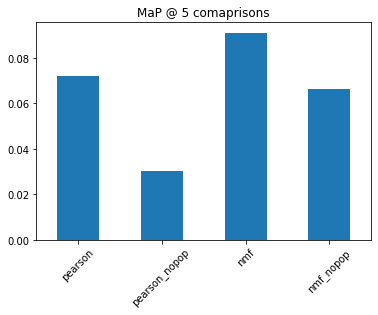

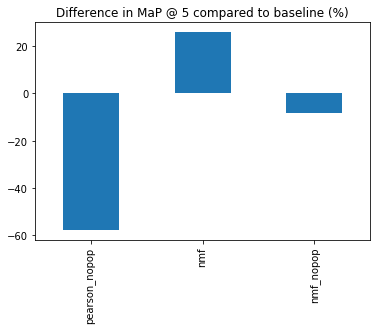

pearson          0.000000 
pearson_nopop   -57.795758
nmf              25.978570
nmf_nopop       -8.397113 
Name: map5, dtype: float64

In [89]:
scores['map5'].plot.bar(rot=45)
plt.title('MaP @ 5 comparisons')
plt.show()

map5 = (scores.iloc[:,0] - scores.iloc[0,0]).div(scores.iloc[0,0]).mul(100)
map5[1:].plot.bar()
plt.title('Difference in MaP @ 5 compared to baseline (%)')
plt.show()

map5

### Coverage

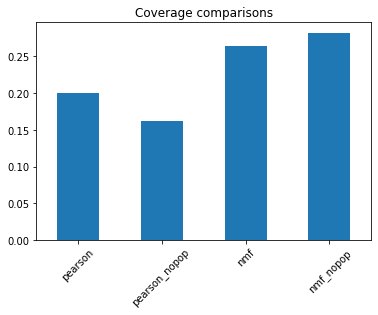

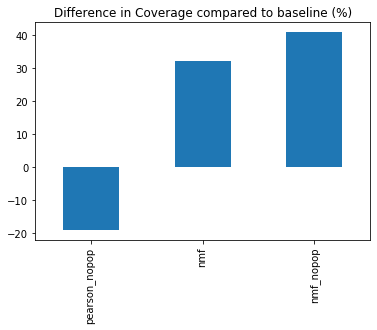

pearson          0.000000 
pearson_nopop   -18.992088
nmf              32.110092
nmf_nopop        40.934818
Name: coverage, dtype: float64

In [90]:
scores['coverage'].plot.bar(rot=45)
plt.title('Coverage comparisons')
plt.show()

cov = (scores.iloc[:,1] - scores.iloc[0,1]).div(scores.iloc[0,1]).mul(100)
cov[1:].plot.bar()
plt.title('Difference in Coverage compared to baseline (%)')
plt.show()

cov

### Personalization

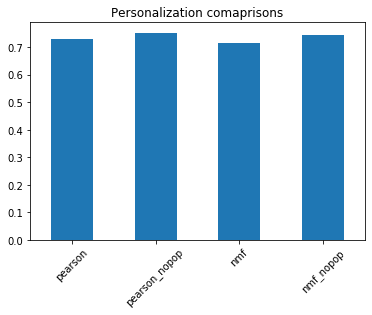

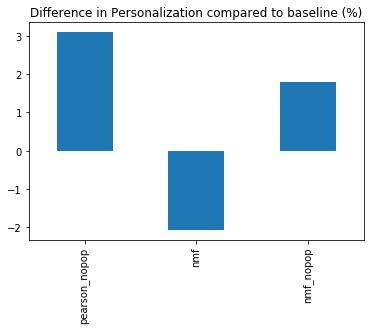

pearson          0.000000
pearson_nopop    3.097224
nmf             -2.064147
nmf_nopop        1.792226
Name: personalization, dtype: float64

In [91]:
scores['personalization'].plot.bar(rot=45)
plt.title('Personalization comparisons')
plt.show()

per = (scores.iloc[:,2] - scores.iloc[0,2]).div(scores.iloc[0,2]).mul(100)
per[1:].plot.bar()
plt.title('Difference in Personalization compared to baseline (%)')
plt.show()

per

### Computational time

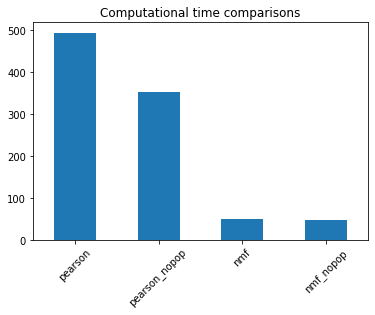

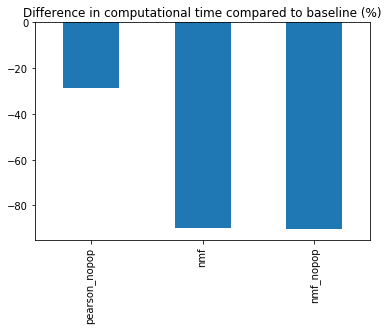

pearson          0.000000 
pearson_nopop   -28.718116
nmf             -89.852388
nmf_nopop       -90.448600
Name: time, dtype: float64

In [92]:
scores['time'].plot.bar(rot=45)
plt.title('Computational time comparisons')
plt.show()

comp = (scores.iloc[:,3] - scores.iloc[0,3]).div(scores.iloc[0,3]).mul(100)
comp[1:].plot.bar()
plt.title('Difference in computational time compared to baseline (%)')
plt.show()

comp

## Conclusions and future work

The straightforward analysis here shows that the NMF similariity model seems to outperform the baseline pearson similarity model in all metrics except for personalization which only exhibits a slight decrease. However, the computational time of the NMF similarity model is about 1/10th of the baseline which makes it the preferable model. It is also observed that culling popular movies did not show much improvement over the chosen model in this analysis schema.

It should be noted that the analysis methodolgy chosen here is simplistic due to time constraints. There is tremendous potential in tuning certain hyperparameters using crossvalidation scores on the training set, especially the number of components for the NMF model, the number of recommendations in the MaP @ k metric, the number of user movies chosen to create similarities etc. Addtionally, genres and text information, including tags and the tag-genome data, were not utilized in this analysis method which could have been used to extract deep insight into user behavior. 